# Analysis of Classification Models on Consumer Personality Analysis Dataset
Dataset: Consumer Personality Analysis (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data)


## Objective
Using consumers' demographics and spending behavior, classify their income levels: low (< $40,000), medium ($40,000-$80,000), and high (> $80,000). These income classes are labeled from 0 to 2. 

## Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report, log_loss
from sklearn.model_selection import learning_curve, cross_val_score

In [2]:
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Preprocessing


Key features to train our 3 classifiers are:
1. Demographics:
    - Age = 2025 - Year_Birth
    - Education: Undergraduate, Postgraduate
    - Marital Status: Alone, In couple
    - Children: How many children in household (Kidhome + Teenhome)
2. Income
3. Customer Tenure: 
    - Customer_Tenure: Today - Dt_Customer (days since joining)
    - Recency: # of day since last purchase
3. Spending behavior & Engagement:
    - Spending: amount spent on wine, fruits, meat, fish, sweets, and gold in last 2 years
    - Web: NumWebPurchases
    - Catalog: NumCatalogPurchases
    - Store: NumStorePurchases
    - WebVisits: NumWebVisitsMonth (in last month)
    - DealPurchases: NumDealsPurchases
    - CampaignResponse: summation of AcceptedCmpX and Response (0 to 6 for levels of campaign engagement)

In [3]:
# Check for feature values to simplify for Education and Marital Status
edu_df = data.drop_duplicates(subset=['Education'])
print(edu_df['Education'])

marital_df = data.drop_duplicates(subset=['Marital_Status'])
print(marital_df['Marital_Status'])


0     Graduation
4            PhD
5         Master
11         Basic
19      2n Cycle
Name: Education, dtype: object
0         Single
2       Together
4        Married
6       Divorced
38         Widow
131        Alone
2093      Absurd
2177        YOLO
Name: Marital_Status, dtype: object


In [4]:
# Demographics
data['Age'] = 2025 - data['Year_Birth']
data['Education'] = data['Education'].replace({'Graduation': 'Bachelor', '2n Cycle': 'Master'})
data['Marital_Status'] = data['Marital_Status'].replace({'Single': 'Alone', 'Together': 'In couple', 'Married': 'In couple', 'Divorced': 'Alone', 'Widow': 'Alone', 'Absurd': 'Alone', 'YOLO': 'Alone'})
data['Children'] = data['Kidhome'] + data['Teenhome']

# Customer Tenure
today_date = pd.to_datetime('2025-02-08')
data['Customer_Tenure'] = (today_date - pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')).dt.days

# Spending Behavior and Engagement 
data['Spending'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
data = data.rename(columns={'NumWebPurchases': 'Web', 'NumCatalogPurchases': 'Catalog', 'NumStorePurchases': 'Store', 'NumWebVisitsMonth': 'WebVisits', 'NumDealsPurchases': 'DealPurchases'})

def categorize_engagement(row):
    if row[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3']].sum() > 0: 
        return 'Early'
    elif row[['AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum() > 0:
        return 'Late'
    else:
        return 'None'
data['Engagement'] = data.apply(categorize_engagement, axis=1)

# Income Class
# Balanced distribution 
# low_threshold, high_threshold = np.percentile(data['Income'], [33, 66])
# bins = [data['Income'].min(), low_threshold, high_threshold, data['Income'].max()]

# Imbalanced distribution of wealth: https://www.pewresearch.org/race-and-ethnicity/2024/05/31/the-state-of-the-american-middle-class/
bins = [0, 40000, 80000, float('inf')]
labels = [0, 1, 2]
data['Income_Class'] = pd.cut(data['Income'], bins=bins, labels=labels)

input_df = data[['Income_Class', 'Age', 'Education', 'Marital_Status', 'Children', 'Customer_Tenure', 'Recency', 'Spending', 'Web', 'Catalog', 'Store', 'WebVisits', 'DealPurchases', 'Engagement']]
input_df.head(10)

,Income_Class,Age,Education,Marital_Status,Children,Customer_Tenure,Recency,Spending,Web,Catalog,Store,WebVisits,DealPurchases,Engagement
0,1,68,Bachelor,Alone,0,4540,58,1617,8,10,4,7,3,Late
1,1,71,Bachelor,Alone,2,3990,38,27,1,1,2,5,2,None
2,1,60,Bachelor,In couple,0,4189,26,776,8,2,10,4,1,None
3,0,41,Bachelor,In couple,1,4016,26,53,2,0,4,6,2,None
4,1,44,PhD,In couple,1,4038,94,422,5,3,6,5,5,None
5,1,58,Master,In couple,1,4170,16,716,6,4,10,6,2,None
6,1,54,Bachelor,Alone,1,4470,34,590,7,3,7,6,4,None
7,0,40,PhD,In couple,1,4294,32,169,4,0,4,8,2,None
8,0,51,PhD,In couple,1,4265,19,46,3,0,2,9,1,Late
9,0,75,PhD,In couple,2,3985,68,49,1,0,0,20,1,Early


### One-hot encoding

In [5]:
input_df = pd.get_dummies(input_df, columns=['Education', 'Marital_Status', 'Engagement'], drop_first=True)
input_df.head(5)

,Income_Class,Age,Children,Customer_Tenure,Recency,Spending,Web,Catalog,Store,WebVisits,DealPurchases,Education_Basic,Education_Master,Education_PhD,Marital_Status_In couple,Engagement_Late,Engagement_None
0,1,68,0,4540,58,1617,8,10,4,7,3,False,False,False,False,True,False
1,1,71,2,3990,38,27,1,1,2,5,2,False,False,False,False,False,True
2,1,60,0,4189,26,776,8,2,10,4,1,False,False,False,True,False,True
3,0,41,1,4016,26,53,2,0,4,6,2,False,False,False,True,False,True
4,1,44,1,4038,94,422,5,3,6,5,5,False,False,True,True,False,True


## Create Training/Testing Sets

In [6]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
input_df = input_df.dropna()
X = input_df.drop('Income_Class', axis=1)
y = input_df['Income_Class']

X = X.astype(np.float32)
y = y.astype(np.int64)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)

(1772, 16)


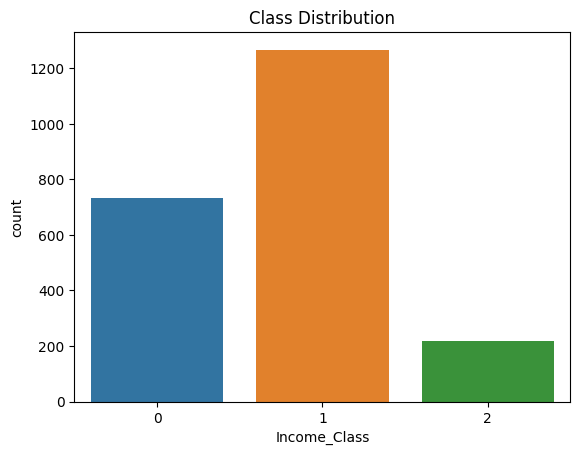

In [7]:
import seaborn as sns

sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

## Neural Network Model

In [8]:
import torch
import random
from torch import nn, optim
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring 
from pyperch.neural.backprop_nn import BackpropModule 

def set_all_seeds(seed): 
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    np.random.seed(seed) 
    random.seed(seed)

set_all_seeds(42)

param_grid = {
    'module__layer_sizes': [(16, 64, 3), (16, 32, 3)],  
    'module__activation': [nn.Tanh(), nn.Sigmoid()],
}

# Define the NeuralNetClassifier
neural_net = NeuralNetClassifier(
    module=BackpropModule,
    optimizer=optim.Adam,
    # optimizer__weight_decay=1e-4,
    max_epochs=500,
    criterion=nn.CrossEntropyLoss(),
    iterator_train__shuffle=True,
    verbose=0,
    lr=0.001,
    module__dropout_percent=0.05,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True)],
)

# Perform grid search
grid_search = GridSearchCV(neural_net, param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best hyperparameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 64, 3); total time=   9.6s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 64, 3); total time=   8.7s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 64, 3); total time=   8.5s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 64, 3); total time=   8.7s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 64, 3); total time=   8.8s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 32, 3); total time=   8.3s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 32, 3); total time=   8.4s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 32, 3); total time=   8.3s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 32, 3); total time=   8.3s
[CV] END module__activation=Tanh(), module__layer_sizes=(16, 32, 3); total time=   8.3s
[CV] END module__activation=Sigmoid(), module__layer_sizes=(

In [9]:
# Evaluate on test set with best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy with best model: ", test_accuracy)

Test accuracy with best model:  0.831081081081081


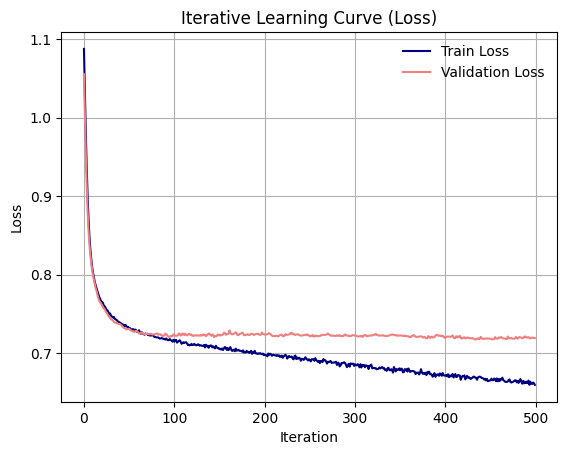

In [10]:
# plot the iterative learning curve (loss)
plt.plot(best_model.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(best_model.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

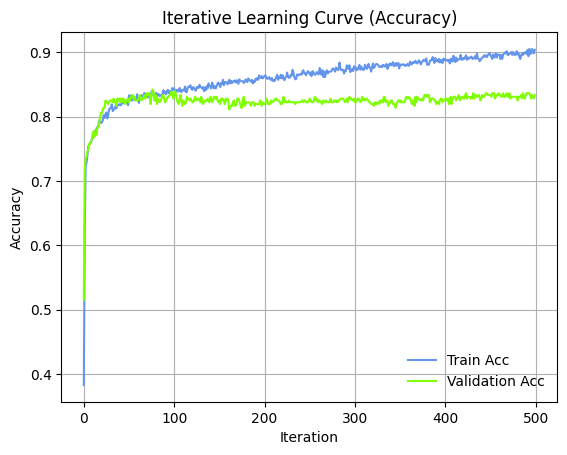

In [11]:
# plot the iterative learning curve (accuracy)
plt.plot(best_model.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(best_model.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

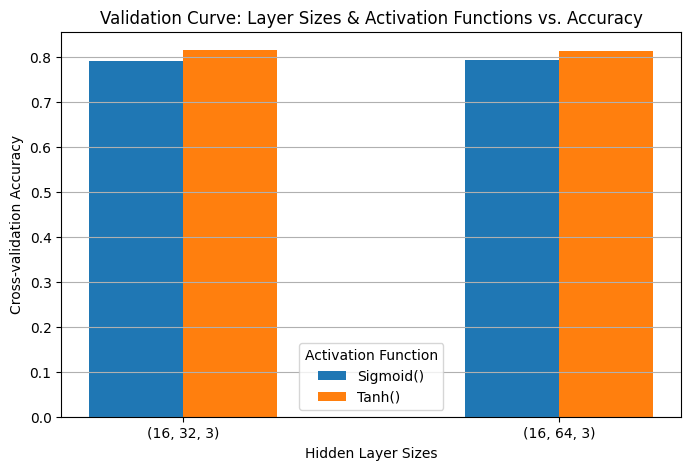

In [33]:
layer_sizes = [params['module__layer_sizes'] for params in grid_search.cv_results_['params']]
activations = [str(params['module__activation']) for params in grid_search.cv_results_['params']]
mean_scores = grid_search.cv_results_['mean_test_score']

unique_layer_sizes = sorted(set(layer_sizes))  # [(16, 32, 3), (16, 64, 3)]
unique_activations = sorted(set(activations))  # ['Sigmoid()', 'Tanh()']

# Create a mapping for index positions
x = np.arange(len(unique_layer_sizes))  
width = 0.25  

plt.figure(figsize=(8, 5))

# Loop through activation functions and plot bars
for i, activation in enumerate(unique_activations):
    scores = [
        mean_scores[j]
        for j in range(len(layer_sizes))
        if activations[j] == activation
    ]
    
    plt.bar(x + i * width, scores, width=width, label=activation) # Offset bars to avoid overlapping
    
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Cross-validation Accuracy")
plt.title("Validation Curve: Layer Sizes & Activation Functions vs. Accuracy")
plt.xticks(x + width / 2, [str(size) for size in unique_layer_sizes])  # Center labels
plt.legend(title="Activation Function")
plt.grid(axis='y')

plt.show()

## SVM Model

In [21]:
from sklearn.svm import SVC

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
f1_scores_svm = [] 

# Perform cross-validation for each kernel
for kernel in kernels:
    svm = SVC(kernel=kernel, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='f1_weighted')  # 5-fold CV
    f1_scores_svm.append(scores.mean())  

    print(f"F1 Score for SVM model with {kernel}: {scores.mean():.4f}")\
    
best_index = np.argmax(f1_scores_svm)
print(f"\nBest kernel: {kernels[best_index]} with F1 score = {f1_scores_svm[best_index]:.4f}")

F1 Score for SVM model with linear: 0.8164
F1 Score for SVM model with rbf: 0.8126
F1 Score for SVM model with poly: 0.8113
F1 Score for SVM model with sigmoid: 0.7424

Best kernel: linear with F1 score = 0.8164


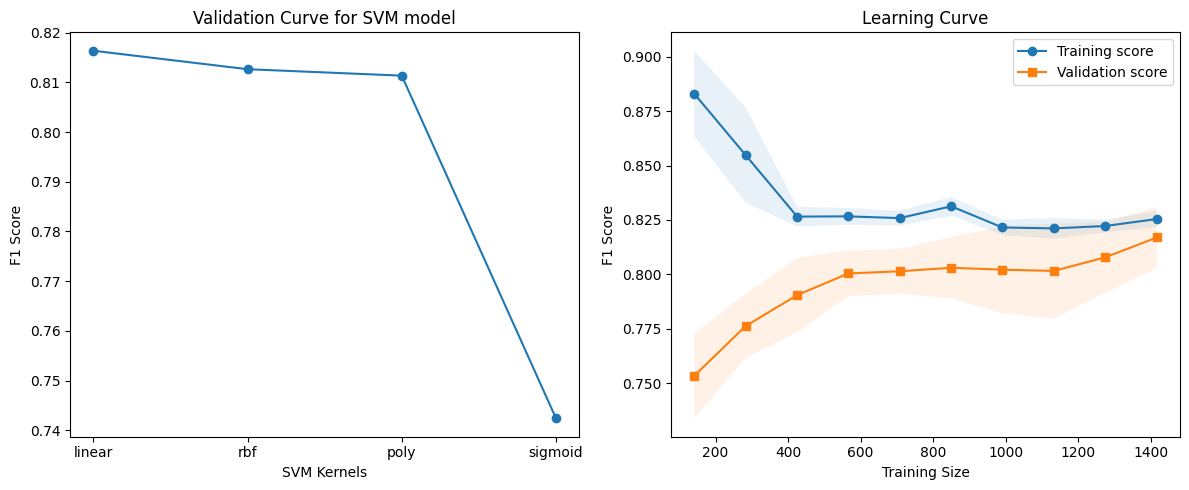

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(kernels, f1_scores_svm, marker='o')
axes[0].set_xlabel('SVM Kernels')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Validation Curve for SVM model')

f1_scorer = make_scorer(f1_score, average='weighted')

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    SVC(kernel='linear', random_state=42),
    X_train, y_train,
    scoring=f1_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),  
    cv=5
)

# Compute mean and std for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
axes[1].plot(train_sizes, train_mean, label="Training score", marker='o')
axes[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[1].plot(train_sizes, test_mean, label="Validation score", marker='s')
axes[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Labels and title
axes[1].set_xlabel("Training Size")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("Learning Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

## k-Nearest Neighbors Model

In [15]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 26)
f1_scores_knn = [] 

for k in k_values:
    # Create and train kNN model with k value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict and evaluate the kNN model with k value
    y_pred_knn = knn.predict(X_test)
    f1_knn = f1_score(y_test, y_pred_knn, average='weighted') 
    f1_scores_knn.append(f1_knn)

    print(f"F1 Score of kNN with k={k}: {f1_knn:.4f}")

best_index = np.argmax(f1_scores_knn)
print(f"\nBest k-value = {k_values[best_index]} with F1 score = {f1_scores_knn[best_index]:.4f}")
    

F1 Score of kNN with k=1: 0.7545
F1 Score of kNN with k=2: 0.7582
F1 Score of kNN with k=3: 0.7566
F1 Score of kNN with k=4: 0.7755
F1 Score of kNN with k=5: 0.7463
F1 Score of kNN with k=6: 0.7788
F1 Score of kNN with k=7: 0.7658
F1 Score of kNN with k=8: 0.7651
F1 Score of kNN with k=9: 0.7794
F1 Score of kNN with k=10: 0.7854
F1 Score of kNN with k=11: 0.7833
F1 Score of kNN with k=12: 0.7838
F1 Score of kNN with k=13: 0.7857
F1 Score of kNN with k=14: 0.7870
F1 Score of kNN with k=15: 0.7863
F1 Score of kNN with k=16: 0.7903
F1 Score of kNN with k=17: 0.7939
F1 Score of kNN with k=18: 0.7992
F1 Score of kNN with k=19: 0.8025
F1 Score of kNN with k=20: 0.8076
F1 Score of kNN with k=21: 0.7964
F1 Score of kNN with k=22: 0.7937
F1 Score of kNN with k=23: 0.7906
F1 Score of kNN with k=24: 0.7904
F1 Score of kNN with k=25: 0.7817

Best k-value = 20 with F1 score = 0.8076


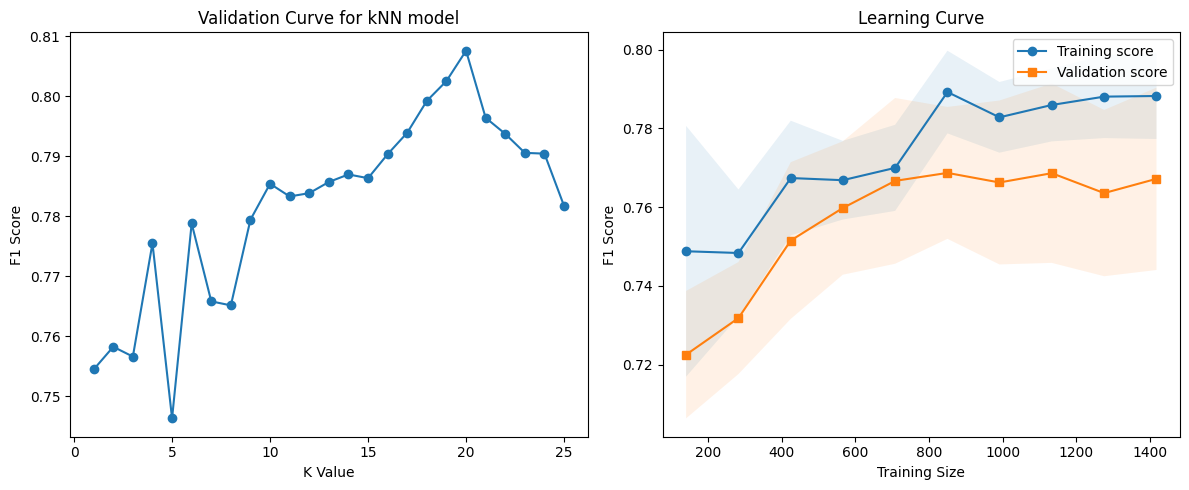

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(k_values, f1_scores_knn, marker='o')
axes[0].set_xlabel('K Value')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Validation Curve for kNN model')

f1_scorer = make_scorer(f1_score, average='weighted')

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=20),  
    X_train, y_train,
    scoring=f1_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10),  
    cv=5
)

# Compute mean and std for shading
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
axes[1].plot(train_sizes, train_mean, label="Training score", marker='o')
axes[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axes[1].plot(train_sizes, test_mean, label="Validation score", marker='s')
axes[1].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# Labels and title
axes[1].set_xlabel("Training Size")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("Learning Curve")
axes[1].legend()

plt.tight_layout()
plt.show()